# Image Classification using Convolutional Neural Networks (CNN)


## Download the dataset and save it locally to Colab

Run only once per connection, downloads are saved in the content folder

When running in Kaggle, please pull the data directly and modify this section

In [ ]:
# Use either Link 1 or Link 2
# If the first link doesn't work, please switch to the second

# Download Link 1
!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
! unzip food11.zip

# Download Link 2
# !wget -O food11.zip https://www.dropbox.com/scl/fi/5a0brv29ur7k3f4pb3oy5/food11.zip?rlkey=bei7fpc3wbnld7n5yv16o8vxk&dl=0
# ! unzip food11.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train/8_5672.jpg        
  inflating: train/8_5678.jpg        
  inflating: train/8_568.jpg         
  inflating: train/8_5704.jpg        
  inflating: train/8_5719.jpg        
  inflating: train/8_572.jpg         
  inflating: train/8_5723.jpg        
  inflating: train/8_5754.jpg        
  inflating: train/8_5768.jpg        
  inflating: train/8_5793.jpg        
  inflating: train/8_5801.jpg        
  inflating: train/8_5803.jpg        
  inflating: train/8_5822.jpg        
  inflating: train/8_5825.jpg        
  inflating: train/8_583.jpg         
  inflating: train/8_5837.jpg        
  inflating: train/8_5851.jpg        
  inflating: train/8_5856.jpg        
  inflating: train/8_5857.jpg        
  inflating: train/8_5924.jpg        
  inflating: train/8_593.jpg         
  inflating: train/8_5938.jpg        
  inflating: train/8_5979.jpg        
  inflating: train/8_5994.jpg        
  inflating: train/8_6002.jpg        
  inflating: train/8_60

## 检查运行环境

In [ ]:
!nvidia-smi

Tue Apr  9 17:05:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Packages

In [ ]:
# exp_name
# denotes the name of the experiment and automatically creates a folder named exp_name containing the checkpoints and some logs
_exp_name = "SEP740_Final_CNN"

In [ ]:
# Importing the necessary function packages and components
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
# torchvision is a graphics library for pytorch that serves the PyTorch deep learning framework
# And it is primarily used to build computer vision models
# torchvision.transforms: mainly for common graphic transformations such as cropping, rotating, etc.
import torchvision.transforms as transforms
from PIL import Image
# Semi-supervised learning may use the "ConcatDataset" and "Subset" suites.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# Progress Bar Component Pack
from tqdm.auto import tqdm
import random
# Pre-trained Model
import torchvision.models as models
import matplotlib.pyplot as plt

from torch.nn import functional as F

# gc.collect()
# torch.cuda.empty_cache()

## Utility Functions

Fix random number generator seed to improve repeatability.

In [ ]:
def same_seeds(seed):
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Cross Entropy Loss Function with Label Smoothing

In [ ]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
  ''' Cross Entropy Loss with label smoothing '''
  def __init__(self, label_smooth=None, class_num=11):
    super().__init__()
    self.label_smooth = label_smooth
    self.class_num = class_num

  def forward(self, pred, target):
    '''
      Args:
      pred: prediction of model output    [N, M]
      target: ground truth of sampler [N]
    '''
    eps = 1e-12

    if self.label_smooth is not None:
      # cross entropy loss with label smoothing
      smooth_target = torch.full((target.size(0), self.class_num), self.label_smooth / (self.class_num - 1)).to(target.device)
      smooth_target.scatter_(1, target.unsqueeze(1), 1 - self.label_smooth + self.label_smooth / (self.class_num - 1))

      loss = F.kl_div(F.log_softmax(pred, dim=1), smooth_target, reduction='none').sum(dim=1)

    else:
      # standard cross entropy loss
      # loss = -1.*pred.gather(1, target.unsqueeze(-1)) + torch.log(torch.exp(pred+eps).sum(dim=1))
      loss = F.cross_entropy(pred, target, reduction='none')

    return loss.mean()

# Transforms

In [ ]:
'''
  transforms.Compose(): mainly to serialize multiple image transformations
  The arguments to Compose() are actually a list, and the elements in that list are the transform operations.
  We have used image shape transformations and color transformations respectively
  The Compose() iterates over the transform operations inside the transforms list
'''

# For testing and validation phase, only resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
])

# For the the testing phase, use train_tfm to produce a variety of images
train_tfm = transforms.Compose([
  # Adjust the image to a fixed shape
  transforms.Resize((128, 128)),
  # Change the original image size to a random size (defaults to 0.8 to 1.0 times the original image)
  # and a random aspect ratio (defaults to 3/4 to 4/3 times)
  # and finally resize to the proper size
  transforms.RandomResizedCrop((128, 128),scale=(0.8,1.0)),
  # Randomly flips a given PIL image horizontally with a given probability, which defaults to 0.5
  transforms.RandomHorizontalFlip(p=0.5),
  # Randomly flip a given PIL image vertically with a given probability, which defaults to 0.5
  transforms.RandomVerticalFlip(p=0.5),
  # Rotate image by angle
  transforms.RandomRotation(90),
  # Randomly change the brightness, contrast, saturation and hue of an image.
  transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
  # ToTensor() should be the last transformation
  transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [ ]:
class FoodDataset(Dataset):
  def __init__(self, path, tfm=test_tfm, files=None):
    super(FoodDataset).__init__()
    self.path = path
    # sorted() Sorting operations on all iterable objects
    # os.listdir() Returns a list of the names of the files or folders contained in the specified folder
    # files is a list of image file addresses and paths.
    self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
    if files != None:
      self.files = files
    self.transform = tfm

  def __len__(self):
    return len(self.files)

  def __getitem__(self,idx):
    fname = self.files[idx]
    im = Image.open(fname)
    im = self.transform(im)

    try:
      label = int(fname.split("/")[-1].split("_")[0])
    except:
      label = -1 # test has no label

    return im,label

# Model

In [ ]:
# Using the VGG16 network
class Food_VGG_Classifier(nn.Module):
  def __init__(self, num_classes=11):
    super(Food_VGG_Classifier, self).__init__()
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    # torch.nn.MaxPool2d(kernel_size, stride, padding)
    # torch.nn.BatchNorm2d(Number of channels of data to be processed, i.e., number of features)
    # input Dimension [3, 128, 128]
    self.model = models.vgg16(weights=VGG16_Weights.DEFAULT)
    self.model.classifier.add_module("add_relu",nn.ReLU(inplace=True))
    self.model.classifier.add_module("add_bn", nn.BatchNorm1d(1000))
    self.model.classifier.add_module("add_dropout",nn.Dropout(p=0.5, inplace=False))
    self.model.classifier.add_module("add_linear",nn.Linear(1000,num_classes))


  def forward(self, x):
    out = self.model(x)
    return out

# Using the ResNet50 network
class Food_ResNet50_Classifier(nn.Module):
  def __init__(self, num_classes=11):
    super(Food_ResNet50_Classifier, self).__init__()
    self.model = models.resnet50(weights='DEFAULT')
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Sequential(
      nn.Linear(num_ftrs, num_classes)
    )

  def forward(self, x):
    out = self.model(x)
    return out


# Hyper Parameters

In [ ]:
config = {
    'SEED': 1122334,    # Set a random seed for reproducibility
    'BATCH_SIZE': 128,   # The number of batch size.
    'N_EPOCHS': 64,     # The number of training epochs.
    'PATIENCE': 15,     # If no improvement in 'patience' epochs, early stop.
    # The number of target types classified, i.e., the number of output layers of the last classification layer fc of the network
    'NUM_CLASSES': 11,
    'LEARNING_RATE': 1e-4, # learning rate
    'WEIGHT_DECAY': 1e-5,  # weight decay


    # train set loading address
    'TRAIN_PATH': './train',
    # valid set loading address
    'VALID_PATH': './valid',
    # test set loading address
    'TEST_PATH': './test'
  }

seed = config['SEED']
same_seeds(seed)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = config['NUM_CLASSES']

# Initialize a model, and put it on the device specified.
model = Food_VGG_Classifier(num_classes).to(device)

# Use Label Smoothing Cross Entropy Loss as criterion
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropyLoss(label_smooth=0.05, class_num=num_classes)

# Initialize optimizer, we tried four optimizers and the results are analyzed in the report
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'])
# Stochastic Gradient Descent = SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'])
# SGD & Momentum Acceleration
# optimizer = torch.optim.SGD(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'], momentum=0.8)
# RMSprop & Momentum Acceleration
# optimizer = torch.optim.RMSprop(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'], momentum=0.8, alpha=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


# Dataloader

In [ ]:
batch_size = config['BATCH_SIZE']
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(config['TRAIN_PATH'], tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(config['VALID_PATH'], tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

  0%|          | 0/79 [00:00<?, ?it/s]

type(train_loss_this):  <class 'float'>
type(train_acc_this):  <class 'float'>
[ Train | 001/064 ] loss = 1.12454, acc = 0.69966


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 001/064 ] loss = 1.11961, acc = 0.70051


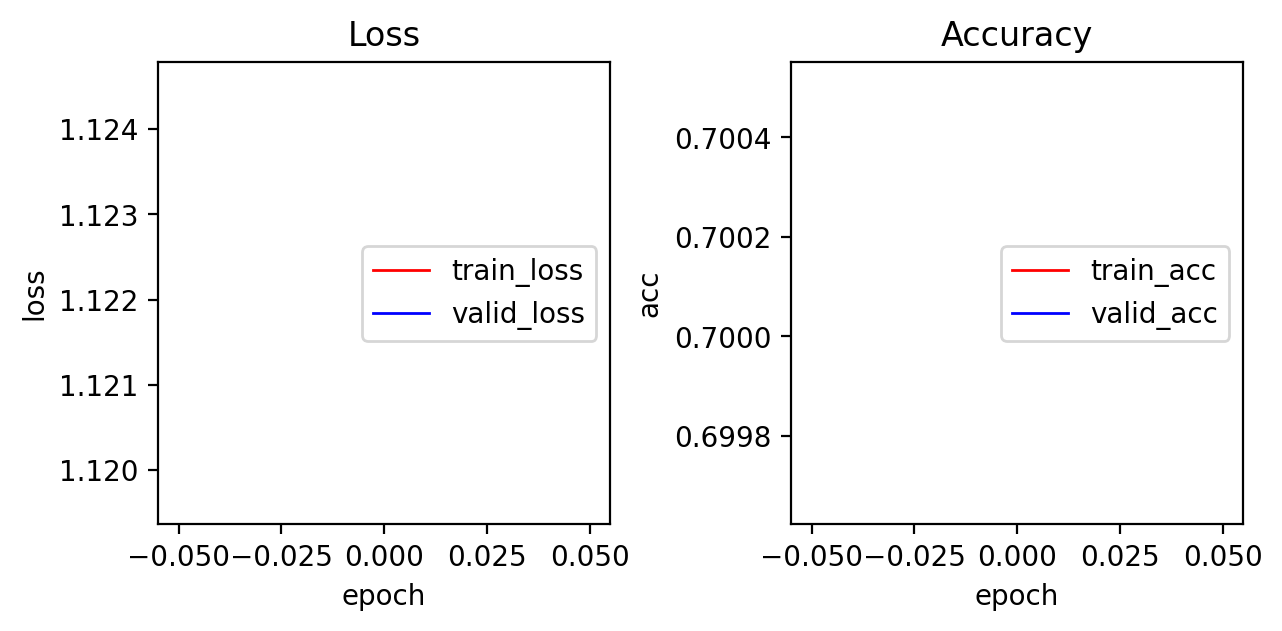

[ Valid | 001/064 ] loss = 1.11961, acc = 0.70051 -> best
Best model found at epoch 0, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
n_epochs = config['N_EPOCHS']
patience = config['PATIENCE']

train_loss_ep = []
valid_loss_ep = []
train_acc_ep = []
valid_acc_ep = []
x = []

for epoch in range(n_epochs):

  # ---------- Training ----------
  # Set the model to train mode
  model.train()
  x.append(epoch)

  # Recording of loss information and accuracy during the training process
  train_loss = []
  train_acc = []

  for batch in tqdm(train_loader):

    # A batch contains image data and corresponding labels
    imgs, labels = batch

    # Converting models and inputs to half-precision allows for faster runs, reduced GPU usage, and only insignificant loss of accuracy
    # imgs = imgs.half()

    # Forward data (ensure data and models are on the same device)
    logits = model(imgs.to(device))

    # compute cross-entropy loss.
    loss = criterion(logits, labels.to(device))

    # First clear the gradient stored in the parameters of the previous step
    optimizer.zero_grad()

    # Calculate the parameter gradient
    loss.backward()

    '''
      Clip the gradient norms for stable training.
      Gradient Clipping：
        Limit the gradient range during model training to avoid the situation where the loss is nan
        When the depth of the neural network gradually increases and the number of network parameters increases,
        the number of gradient multiplication terms in the chain rule during backpropagation increases,
        which is more likely to cause gradient vanishing and gradient explosion
        One of the solutions to the gradient explosion problem is to perform gradient clipping
        i.e. to set an upper limit on the size of the gradient
      torch.nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=2)
        parameters：Parameters of the iterable network for implementing gradient tailoring
        max_norm：The upper limit of the number of paradigms for the gradient of the parameters of this group of networks
              and the main parameter to be set for gradient trimming
        norm_type：paradigm type (math.)
    '''
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_acc.append(acc.item())

  train_loss_this = sum(train_loss) / len(train_loss)
  train_acc_this = sum(train_acc) / len(train_acc)

  # Print the information.
  print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss_this:.5f}, acc = {train_acc_this:.5f}")
  train_loss_ep.append(train_loss_this)
  train_acc_ep.append(train_acc_this)

  # ---------- Validation ----------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.
  valid_loss = []
  valid_acc = []

  # Iterate the validation set by batches.
  for batch in tqdm(valid_loader):

    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    # imgs = imgs.half()

    # We don't need gradient in validation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs.to(device))

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels.to(device))

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    valid_loss.append(loss.item())
    valid_acc.append(acc.item())

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_loss_this = sum(valid_loss) / len(valid_loss)
  valid_acc_this = sum(valid_acc) / len(valid_acc)

  # Print the information.
  print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss_this:.5f}, acc = {valid_acc_this:.5f}")

  # Visualization
  valid_loss_ep.append(valid_loss_this)
  valid_acc_ep.append(valid_acc_this)

  plt.figure(figsize=(8, 3), dpi=200)
  plt.subplots_adjust(wspace=0.4)
  plt.subplot(1, 2, 1)
  try:
    train_loss_lines.remove(train_loss_lines[0])
    valid_loss_lines.remove(valid_loss_lines[0])
  except Exception:
    pass
  train_loss_lines = plt.plot(x, train_loss_ep, 'r', lw=1)
  valid_loss_lines = plt.plot(x, valid_loss_ep, 'b', lw=1)
  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(["train_loss","valid_loss"])

  plt.subplot(1, 2, 2)
  try:
    train_acc_lines.remove(train_acc_lines[0])
    val_acc_lines.remove(val_acc_lines[0])
  except Exception:
    pass
  train_acc_lines = plt.plot(x, train_acc_ep, 'r', lw=1)
  val_acc_lines = plt.plot(x, valid_acc_ep, 'b', lw=1)

  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("acc")
  plt.legend(["train_acc", "valid_acc"])

  plt.show()
  plt.pause(0.1)

  # update logs
  if valid_acc_this > best_acc:
    with open(f"./{_exp_name}_log.txt","a"):
      print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss_this:.5f}, acc = {valid_acc_this:.5f} -> best")
  else:
    with open(f"./{_exp_name}_log.txt","a"):
      print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss_this:.5f}, acc = {valid_acc_this:.5f}")


  # save models
  # Apply the early stopping method
  if valid_acc_this > best_acc:
    print(f"Best model found at epoch {epoch}, saving model")
    torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
    best_acc = valid_acc_this
    stale = 0
  else:
    stale += 1
    if stale > patience:
      print(f"No improvment {patience} consecutive epochs, early stopping")
      break

# Dataloader for test

In [ ]:
# Construct test datasets.
test_set = FoodDataset(config['TEST_PATH'], tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [ ]:
model_best = Food_VGG_Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
  for data,_ in tqdm(test_loader):
    test_pred = model_best(data.to(device))
    test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
    prediction += test_label.squeeze().tolist()

In [ ]:
# create test csv
def pad4(i):
  return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("test_result.csv",index = False)

In [ ]:
# Automatically download files to the browser's default local storage location
from google.colab import files
files.download('test_result.csv')
files.download('SEP740_Final_CNN.ckpt')

# Visualize the model structure

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Food_VGG_Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)